In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)


Данные: набор востребованности такси в городе Нью Йорк с шагом в 1 час.

In [2]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index(['timestamp']).asfreq('h')
data.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 01:00:00,6210
2014-07-01 02:00:00,3820
2014-07-01 03:00:00,2369
2014-07-01 04:00:00,2221


In [3]:
y = data.value.values.reshape(-1, 1)

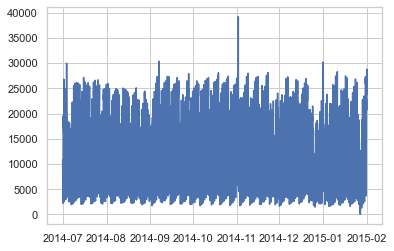

In [5]:
plt.plot(data.index, y)

Данные во временных рядах можно рассматривать как в чистом виде, так и преобразовать.

Попробуем скользящее средние и скользящие СКО

<AxesSubplot:xlabel='timestamp'>

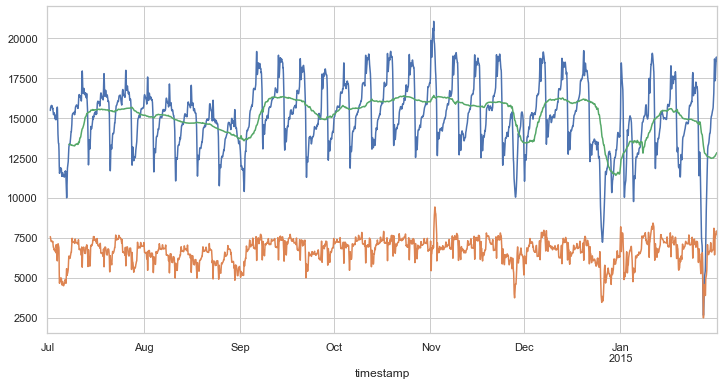

In [4]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
# create moving-averages
data['value'].rolling(24).mean().plot()
data['value'].rolling(24).std().plot()
data['value'].rolling(24*7).mean().plot()

Дифференцирование

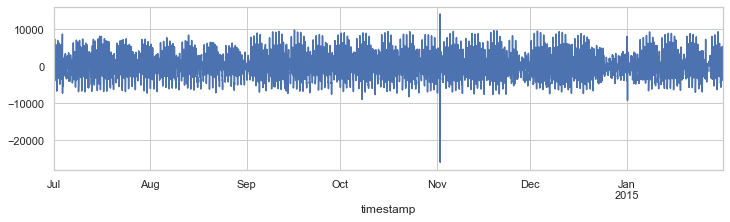

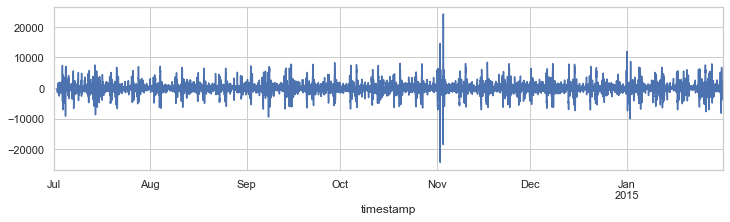

In [5]:
plt.rc('figure',figsize=(12,3))
plt.rc('font',size=15)

data.value.diff(1).plot(); plt.show()
data.value.diff(24).diff(1).plot(); plt.show()

Простое разложение

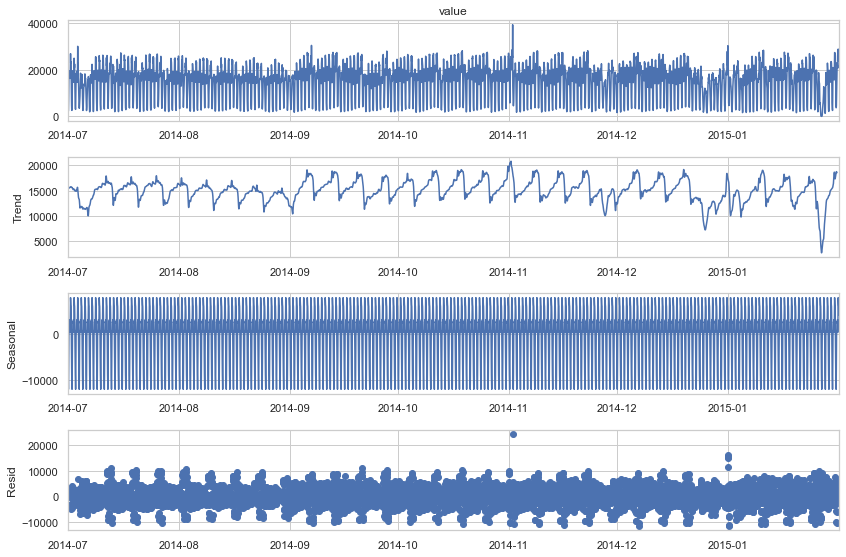

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(data.value,model='additive')
fig = result.plot()

сравнение (остаток, метрика) от предсказания простой моделью

c:\users\ronkin\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


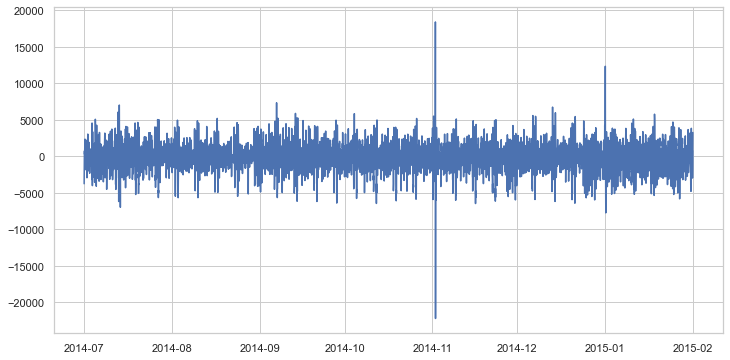

In [7]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
forecaster = ExponentialSmoothing(y,seasonal_periods=48,trend="add",seasonal="add").fit()
predicts = forecaster.predict(start=0, end=len(y)-1)

plt.rc('figure',figsize=(12,6))
plt.plot(data.index, y.reshape(-1) - predicts)

Более тонкие разложения, например по т.н. внутренним модам

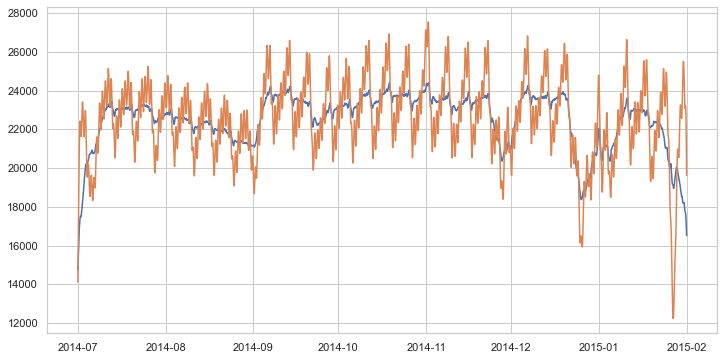

In [8]:
import dsatools 
y_dec = dsatools.decomposition.vmd(y.reshape(-1)[:], order =4)
plt.plot(data.index[1:-1],y_dec[0,1:-1])

y_dec = dsatools.decomposition.vmd(y.reshape(-1)[:], order =2)
plt.plot(data.index[1:-1],y_dec[0,1:-1])

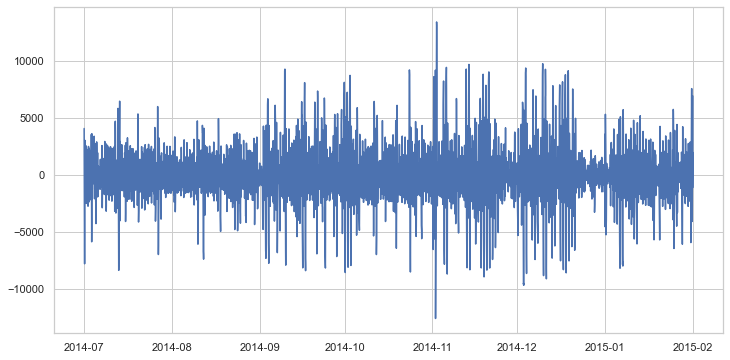

In [19]:
y_dec = dsatools.decomposition.emd(y.reshape(-1)[:], order =10)
plt.plot(data.index[1:-1],y_dec[0,1:-1]); plt.show()


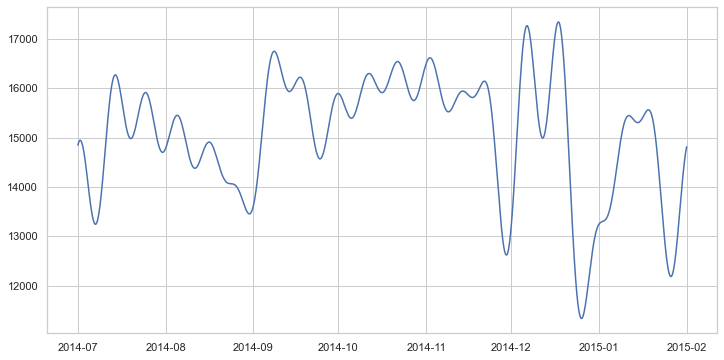

In [23]:
y_dec = dsatools.decomposition.hvd(y.reshape(-1)[:], order =2)
plt.plot(data.index[1:-1],y_dec[0,1:-1]); plt.show()

Ряд может быть обработан на основе четких правил

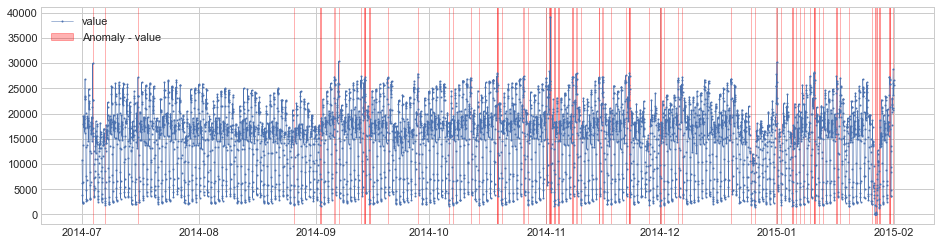

In [25]:
from adtk.detector import QuantileAD
from adtk.visualization import plot
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(data)
plot(data, anomaly=anomalies, anomaly_color='red');

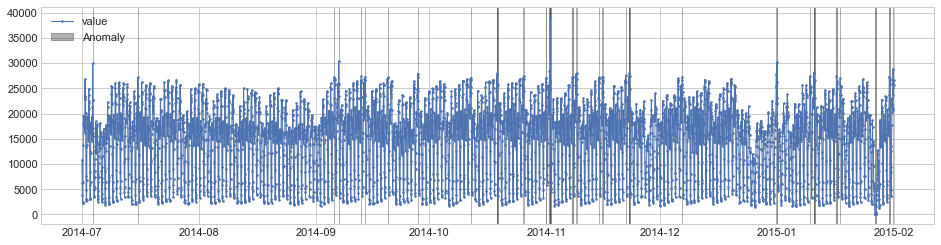

In [125]:
from adtk.detector import ThresholdAD
threshold_val = ThresholdAD(high=27000, low=1000)
anomalies_thresh = threshold_val.detect(data.value)
anomalies_thresh.value_counts()
plot(data, anomaly=anomalies_thresh, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='black');

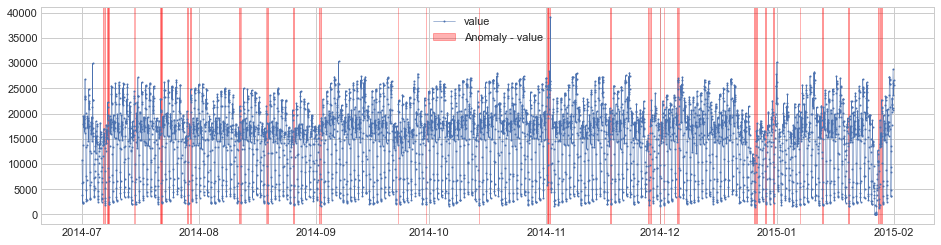

In [145]:
from adtk.detector import VolatilityShiftAD
volatility_shift_ad = VolatilityShiftAD(c=1.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(data)
plot(data, anomaly=anomalies, anomaly_color='red');

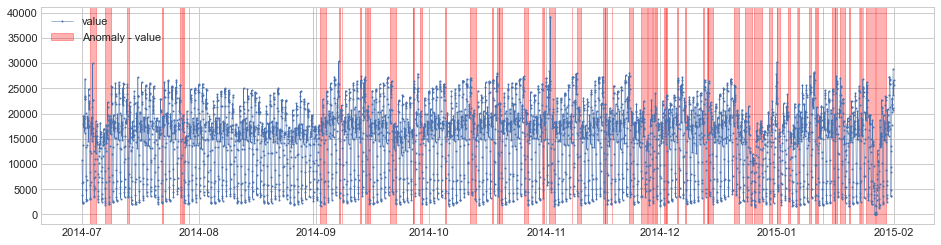

In [160]:
from adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=0.2, side='both', window=50)
anomalies = level_shift_ad.fit_detect(data)
plot(data, anomaly=anomalies, anomaly_color='red');

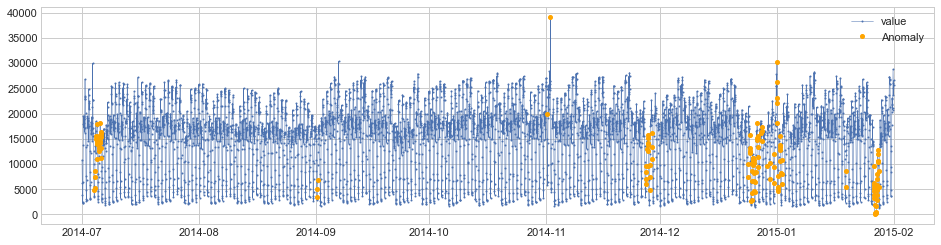

In [26]:
from adtk.detector import SeasonalAD
seasonal_vol = SeasonalAD()
anomalies = seasonal_vol.fit_detect(data.value)
anomalies.value_counts()

plot(data, anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker");

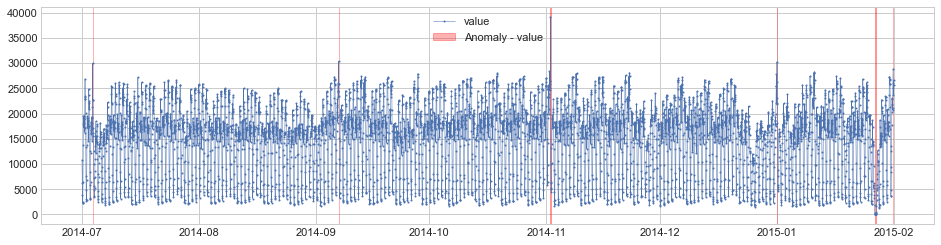

In [174]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=0.9)
anomalies = iqr_ad.fit_detect(data)
plot(data, anomaly=anomalies, anomaly_color='red');

Также могут быть использованы специализированные алгоритмы

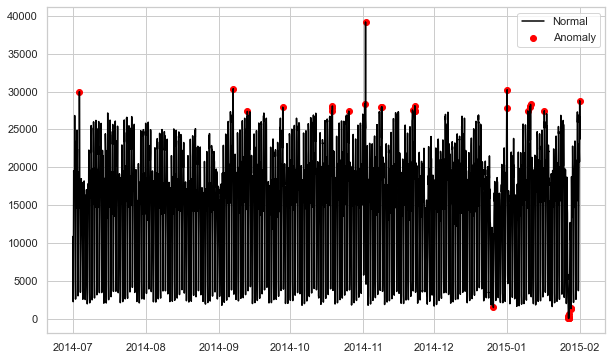

In [90]:
from sklearn.ensemble import IsolationForest

outliers_fraction = 0.007

model =  IsolationForest(contamination=outliers_fraction)
model.fit(data.value.values.reshape(-1, 1))

data['anomaly_IF'] = model.predict(y)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = data.loc[data['anomaly_IF'] == -1, ['value']] #anomaly

ax.plot(data.index, data['value'], color='black', label = 'Normal')
ax.scatter(a.index,a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

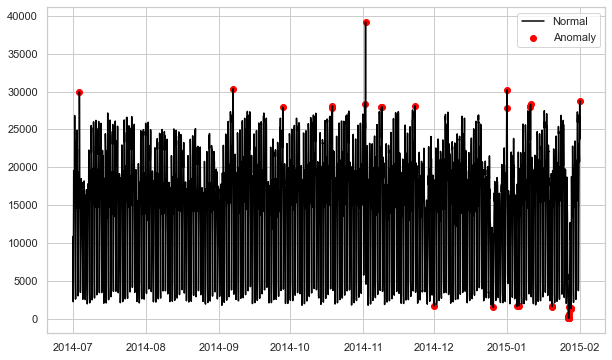

In [91]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(novelty=True)

lof.fit(y)

data['anomaly_LOF'] = lof.predict()


fig, ax = plt.subplots(figsize=(10,6))

a = data.loc[data['anomaly_LOF'] == -1, ['value']] #anomaly

ax.plot(data.index, data['value'], color='black', label = 'Normal')
ax.scatter(a.index,a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

[   7    9   14 5130] [ 2  1 -1  0]


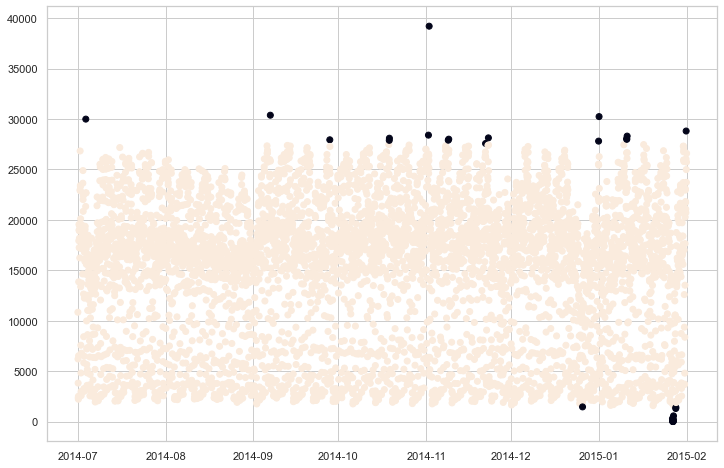

In [93]:
from sklearn.cluster import DBSCAN, KMeans
model=DBSCAN(eps = 100.)
# model = KMeans(n_clusters=10)

model.fit(y)
colors = model.labels_
cls,counts = np.unique(colors, return_counts=True)
sort_idx = np.argsort(counts)#[::-1]
print(counts[sort_idx], cls[sort_idx])
plt.scatter(data.index, y, c = colors == cls[sort_idx][-1])

По мимо sklearn есть и другие библиотеки работы с аномалиями, например https://pyod.readthedocs.io/en/latest/

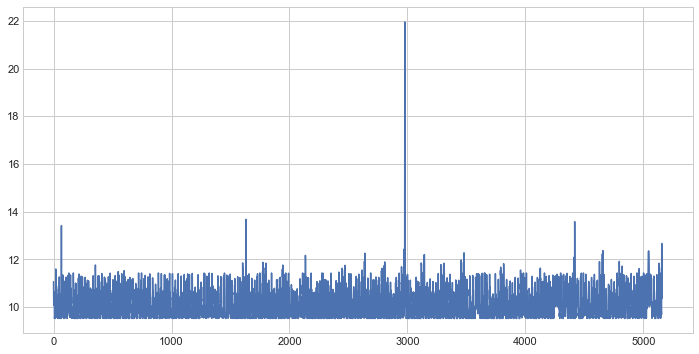

In [50]:
import pyod.models
from pyod.models.gmm import GMM

clf = GMM( n_components=2, )
clf.fit(y)
y_scores = clf.decision_scores_
plt.plot(y_scores)

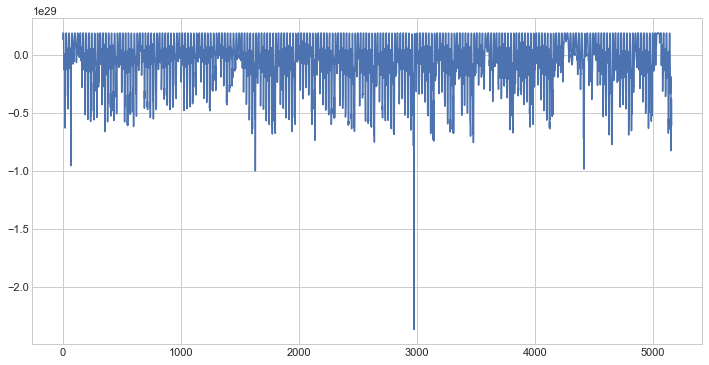

In [41]:
from pyod.models.ocsvm import OCSVM
pyod.models.anogan.AnoGAN
clf = OCSVM(kernel='poly',degree=3)
clf.fit(y)
y_scores = clf.decision_scores_
plt.plot(y_scores)

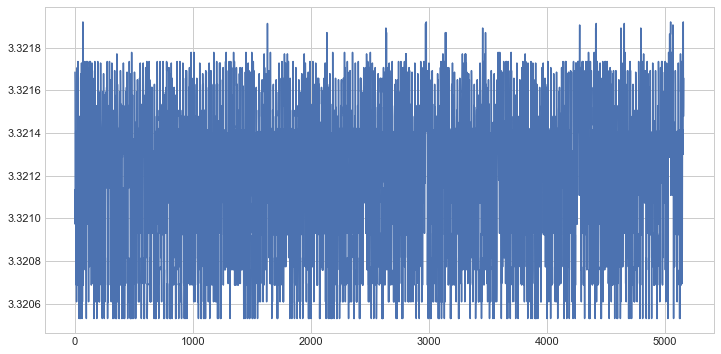

In [44]:
from pyod.models.hbos import HBOS

clf = HBOS(n_bins=100, alpha=0.1, tol=0.5, contamination=0.1)
clf.fit(y)
y_scores = clf.decision_scores_
plt.plot(y_scores)

в данной библиотеки pyod можно в т.ч. реализовать попробовать на основе восстановления автоэнокдером

In [45]:
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder

clf = AutoEncoder(hidden_neurons =[1,125, 125, 1])
clf.fit(y)
y_scores = clf.decision_scores_

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1)                 2         
                                                                 
 dropout_18 (Dropout)        (None, 1)                 0         
                                                                 
 dense_22 (Dense)            (None, 1)                 2         
                                                                 
 dropout_19 (Dropout)        (None, 1)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                 2         
                                                                 
 dropout_20 (Dropout)        (None, 1)                 0         
                                                                 
 dense_24 (Dense)            (None, 125)              

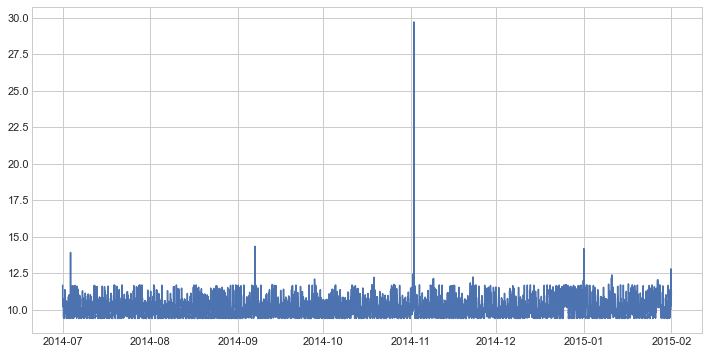

In [48]:
plt.plot(data.index,y_scores); plt.show()


https://www.kaggle.com/code/joshuaswords/time-series-anomaly-detection

https://github.com/rob-med/awesome-TS-anomaly-detection

https://github.com/yzhao062/anomaly-detection-resources